In [131]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from itertools import product

# preprocessing
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# handling detection
from sklearn.ensemble import IsolationForest

# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# hyper-parameter tunning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer


# evaluation
from sklearn.metrics import\
    accuracy_score, confusion_matrix, classification_report, \
    f1_score, recall_score, balanced_accuracy_score, precision_score

# storing the best model
import pickle


In [146]:
pd.set_option('display.max_columns', 30)  # Adjust the number as needed

%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 


# Goals

> notes :  
    - ❌ convert N_Days to 3 groups based on if there status, for example if the patient has died or ... 
    - ✅ convert Age from days to years ?
    - the target labels, you actually divide them into two main groups, Survived / Dead . because groups CL and C represent survived people
    - 
- outliers
    - you can still work on `Bilirubin` 
    
    
>  the given data is already preprocessed and the missing values are filled with the average of others

C  -> alive at N days  
CL -> alive at N days due to liver transplant  
D  -> dead at N days  

# Preprocessing

In [147]:
data = pd.read_csv("../data/train.csv")
data = pipeline.fit_transform(data)

In [ ]:
# fixing the different metrics problem for some features
# solutions :
#   convert the metrics to a unique metric for all the features
#   scale the data

### Handling outliers

In [ ]:
def box_plotter(df, features=None) :
    fig_x = 3
    fig_y = 5
    fig, axes = plt.subplots(fig_x, fig_y, figsize=(10, 5), layout="constrained")
    df = df.select_dtypes(["int", "float"]) if features==None else df.select_dtypes(["int", "float"])[features]
    for index, column in zip(product(range(fig_x), range(fig_y)), df) :
        sns.boxplot(
            df[column],
            ax=axes[index[0], index[1]],
        )
        axes[index[0], index[1]].set_title(column)

#### IQR removal

In [132]:
def remove_outliers(column: pd.Series, q1=0.25, q2=0.75) :
    Q1 = column.quantile(q1)
    Q3 = column.quantile(q2)
    IQR = Q3 - Q1
    filtered_column = column[
        (column >= (Q1 - 1.5*IQR)) & (column <= (Q3 + 1.5*IQR))
    ] # changed > to >= , and > to >=
      # in this case, columns like 'adults' won't have any problem
    return filtered_column

selected_features = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]
data[selected_features] = data[selected_features].apply(
    func=remove_outliers,
).dropna()

new_data = data.dropna()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7897,7897,1455,Placebo,16898,F,N,N,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,151.0,9.8,3.0,C
7899,7899,1413,Placebo,24622,F,N,N,N,N,1.3,262.0,3.73,65.0,2045.0,89.90,78.0,181.0,11.0,3.0,D
7901,7901,1492,Placebo,17031,F,N,Y,N,N,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7903,7903,3584,D-penicillamine,22960,M,N,Y,N,N,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,D


In [1]:
box_plotter(new_data)

NameError: name 'box_plotter' is not defined

#### IsolationForest

In [150]:
def single_outlier_removal(column: pd.DataFrame, n_estimators=50, contamination=0.03) :
    # single feature
    isolation_forest =IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, max_features=1)
    isolation_forest.fit(column)

    tmp_df = column.copy()
    tmp_df["anomaly"] = isolation_forest.predict(column)
    tmp_df = tmp_df.query("anomaly == 1")
    tmp_df.drop(columns="anomaly", inplace=True)
    return tmp_df

outlier_list = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]
chosen_indexes = set()
for feature in data[outlier_list] :
    new = single_outlier_removal(data[[feature]])
    indexes = new.index.tolist()
    chosen_indexes = set(indexes) if not chosen_indexes else chosen_indexes
    chosen_indexes = chosen_indexes.intersection(set(indexes))
new_data = data.iloc[list(chosen_indexes), :]
new_data

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug,no_Edema_no_diuretic,Edema_no_diuretic,Edema_diuretic
0,-0.942430,0.858448,1,0,0,0,-0.077237,-0.176908,-0.572940,1.160785,-0.113334,1.336304,-0.996442,1.472341,-1.189049,3,2,1,1,0,0
1,0.497025,0.234760,0,0,0,0,-0.444429,0.068784,-0.024043,-0.275420,-0.197909,0.414968,-0.520497,1.095026,0.474024,3,0,0,1,0,0
2,1.277529,-1.262634,0,0,1,1,0.185043,-0.263923,0.004846,0.620561,-0.413812,0.097266,-1.243933,-0.757248,1.369525,4,2,0,0,0,1
3,0.498852,0.023603,0,0,0,0,-0.523113,-0.484022,-0.139601,-0.341301,-0.086017,-0.887610,-0.368194,0.043117,0.090238,3,0,0,1,0,0
4,-1.135271,-0.466107,0,0,1,0,-0.391973,-0.023351,0.293739,-0.275420,-0.333965,0.224347,-0.368194,0.374697,-0.037691,4,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7899,-0.564059,1.698184,0,0,0,0,-0.339517,-0.453311,0.524853,-0.249068,0.119905,-0.506368,-0.710875,-0.963057,0.474024,3,2,0,1,0,0
7900,-0.789802,-0.416919,0,0,0,0,-0.470657,-0.212738,0.033735,-0.604825,-0.098625,-0.728759,2.068644,0.900652,-0.933192,2,0,1,1,0,0
7901,-0.491858,-0.364741,0,0,1,0,-0.444429,-0.463548,-0.341826,-0.288596,-0.197909,0.561521,-0.710875,0.134588,-0.805263,4,0,0,1,0,0
7903,1.420103,1.246520,1,0,1,0,-0.496885,-0.524971,-2.306298,-0.683882,-0.427470,-1.173542,0.050637,-0.505705,-0.037691,4,2,1,1,0,0


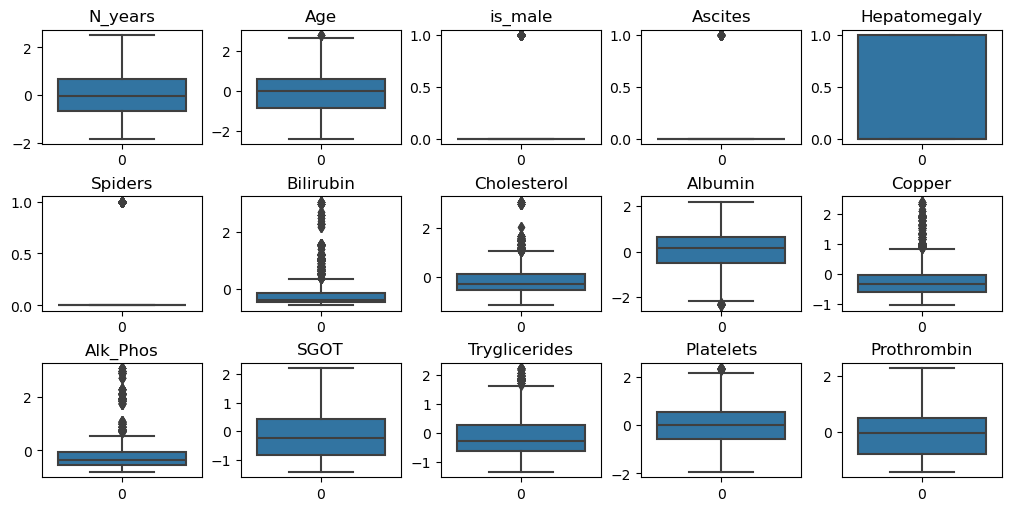

In [149]:
box_plotter(new_data)

### Imbalance Data

In [151]:
new_data.head()

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug,no_Edema_no_diuretic,Edema_no_diuretic,Edema_diuretic
0,-0.942430,0.858448,1,0,0,0,-0.077237,-0.176908,-0.572940,1.160785,-0.113334,1.336304,-0.996442,1.472341,-1.189049,3,2,1,1,0,0
1,0.497025,0.234760,0,0,0,0,-0.444429,0.068784,-0.024043,-0.275420,-0.197909,0.414968,-0.520497,1.095026,0.474024,3,0,0,1,0,0
2,1.277529,-1.262634,0,0,1,1,0.185043,-0.263923,0.004846,0.620561,-0.413812,0.097266,-1.243933,-0.757248,1.369525,4,2,0,0,0,1
3,0.498852,0.023603,0,0,0,0,-0.523113,-0.484022,-0.139601,-0.341301,-0.086017,-0.887610,-0.368194,0.043117,0.090238,3,0,0,1,0,0
4,-1.135271,-0.466107,0,0,1,0,-0.391973,-0.023351,0.293739,-0.275420,-0.333965,0.224347,-0.368194,0.374697,-0.037691,4,0,0,1,0,0


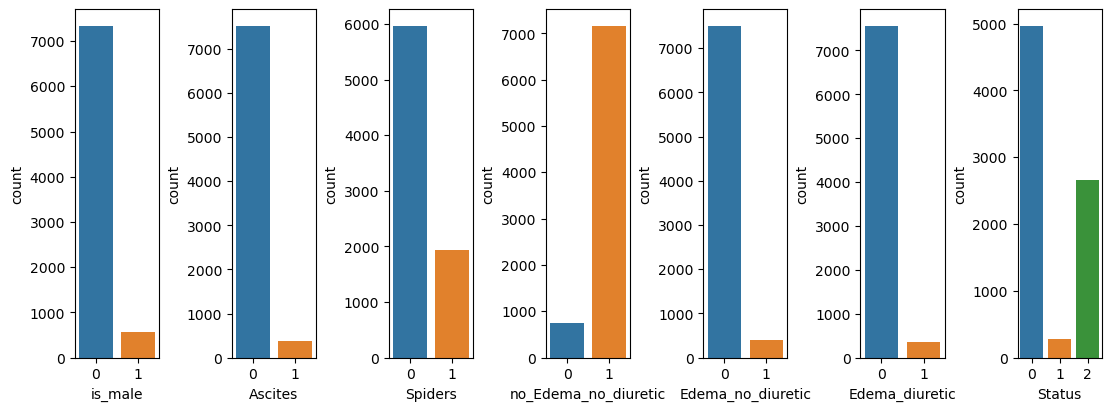

In [199]:
fig, axes = plt.subplots(1, 7, figsize=(11, 4), layout="constrained")

for index, column in enumerate(["is_male", "Ascites", "Spiders", "no_Edema_no_diuretic", "Edema_no_diuretic", "Edema_diuretic", "Status"]) :
    sns.countplot(
        data,
        x=column,
        ax=axes[index],
    )

`Edema` features is so imbalanced, and as a result the 3 features we extracted from it are also extremely imbalanced

#  EDA

In [5]:
eda_pipeline = Pipeline(
    [
        ("EDA_preprocessing", FunctionTransformer(func=pre_process1, validate=False, kw_args={"inplace":False})),
    ]
)
eda_data = eda_pipeline.fit_transform(data)

In [6]:
profile = ProfileReport(eda_data, explorative=True)
profile.to_file("EDA.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:  81%|████████  | 21/26 [00:00<00:00, 36.35it/s, Calculate auto correlation]     /Users/artmissg/anaconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'N'')
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 143.16it/s]


In [7]:
import warnings
warnings.filterwarnings('ignore')

#### N_days

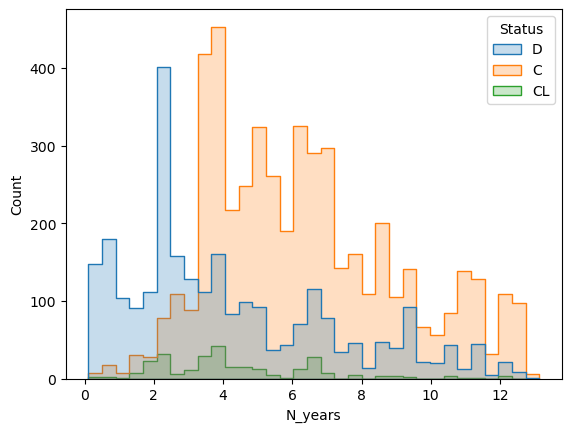

In [8]:
sns.histplot(
    eda_data, 
    x="N_years",
    hue="Status",
    element='step', # bars, step, poly
);

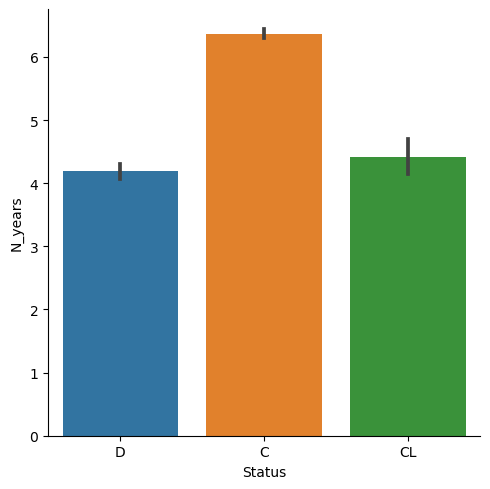

In [9]:
sns.catplot(
    data=eda_data,
    x='Status',
    y="N_years",
    kind='bar',
);

In [10]:
eda_data.head()

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug
0,2.736986,58.991781,True,False,False,False,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D,True
1,7.052055,52.704110,False,False,False,False,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C,False
2,9.391781,37.608219,False,False,True,True,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D,False
3,7.057534,50.575342,False,False,False,False,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C,False
4,2.158904,45.638356,False,False,True,False,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C,False


# Feature Engineering

In [12]:
# separating teh N_years for each of the target group
# > the result of doing this is data-leakage, so wrong choice:)

# playground

In [141]:
# Function to preprocess the data
def pre_process1(data, inplace=False):
    if not inplace :
        data = data.copy()

    data.drop(columns=["id"], inplace=True)
    # Convert number of days into years for more clarification
    data["N_Days"] = (data["N_Days"] / 365)
    data.rename(columns={"N_Days": "N_years"}, inplace=True)
    # Some of the users took actual medicine and others didn't
    data["took_drug"] = (data["Drug"] == "D-penicillamine")
    data.drop(columns=["Drug"], inplace=True)
    # Convert age from days into years for more clarification
    data["Age"] = (data["Age"] / 365)
    # Fixing sex feature
    data["Sex"] = data["Sex"] == "M"
    data.rename(columns={"Sex": "is_male"}, inplace=True)
    data["Ascites"] = data["Ascites"] == "Y"
    data["Hepatomegaly"] = data["Hepatomegaly"] == "Y"
    data["Spiders"] = data["Spiders"] == "Y"
    
    return data  # Return the modified DataFrame

def pre_process2(data, inplace=False):
    if not inplace :
        data = data.copy()
        
    encoded_frame = pd.DataFrame(
        OneHotEncoder().fit_transform(data[["Edema"]]).toarray(),
        columns=["no_Edema_no_diuretic", "Edema_no_diuretic", "Edema_diuretic"]
    )
    data = pd.concat(
        [data, encoded_frame],
        axis=1,
    )
    data.drop(columns=["Edema"], inplace=True)

    # fix True False Features
    data = data.astype(
        {
            "is_male": float,
            "Ascites": int,
            "Spiders": int,
            "took_drug": int,
            "Hepatomegaly": int,
        }
    )

    data = data.convert_dtypes()

    # scale the data using z-score scaler
    scaler = StandardScaler()
    scaled = scaler.fit_transform(
        data[
            [
                "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
                "Age", "N_years",
            ]
        ]
    )
    data[
        [
            "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
            "Age", "N_years"
        ]
    ] = scaled


    # # fixing Status dtype using TargetEncoding
    if "Status" in data.columns :
        encoder = LabelEncoder()
        data["Status"] = encoder.fit_transform(data["Status"])


    return data  # Return the modified DataFrame

def beta_preprocess(data, inplace=False) :
    if not inplace :
        data = data.copy()
        
    # Isolation Forest
    def single_outlier_removal(column: pd.DataFrame, n_estimators=50, contamination=0.03) :
        # single feature
        isolation_forest =IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, max_features=1)
        isolation_forest.fit(column)

        tmp_df = column.copy()
        tmp_df["anomaly"] = isolation_forest.predict(column)
        tmp_df = tmp_df.query("anomaly == 1")
        tmp_df.drop(columns="anomaly", inplace=True)
        return tmp_df
    outlier_list = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]
    chosen_indexes = set()
    for feature in data[outlier_list] :
        new = single_outlier_removal(data[[feature]])
        indexes = new.index.tolist()
        chosen_indexes = set(indexes) if not chosen_indexes else chosen_indexes
        chosen_indexes = chosen_indexes.intersection(set(indexes))
    data = data.iloc[list(chosen_indexes), :]

    # # fixing Status dtype using TargetEncoding
    if "Status" in data.columns :
        encoder = LabelEncoder()
        data["Status"] = encoder.fit_transform(data["Status"])

    return data  # Return the modified DataFrame

# Column Transformer to apply the pre_process function to the entire DataFrame
pipeline = Pipeline(
    [
        ("EDA_preprocessing", FunctionTransformer(func=pre_process1, validate=False)),
        ("model_preprocessing", FunctionTransformer(func=pre_process2, validate=False)),
    ]
)

beta_pipeline = Pipeline(
    [
        ("EDA_preprocessing", FunctionTransformer(func=pre_process1, validate=False)),
        ("model_preprocessing", FunctionTransformer(func=pre_process2, validate=False)),
        ("beta_preprocess", FunctionTransformer(func=beta_preprocess, validate=False)),
    ]
)

In [ ]:
data = pd.read_csv("../data/train.csv")
data = pipeline.fit_transform(data)

# Modeling

In [121]:
# Bayesian search using skopt
np.int = np.int_ # fo fix the conflict with python version

opt = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        "n_estimators": Integer(10, 100),
        "max_depth": Integer(5, 50),
        "num_class": Categorical([3]),
        "learning_rate": Real(0.01, 0.4, prior="uniform"),
        "booster": Categorical(["gbtree", "gblinear"]),
        "device": Categorical(["gpu"]),
        # "early_stopping_rounds": Categorical([0, 5, 10, 20]),
        # "eval_metric": ['merror','mlogloss'],
    },
    n_iter=32,
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=9090,
)

In [122]:
data.head()

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug,no_Edema_no_diuretic,Edema_no_diuretic,Edema_diuretic
0,-0.942430,0.858448,1,0,0,0,-0.077237,-0.176908,-0.572940,1.160785,-0.113334,1.336304,-0.996442,1.472341,-1.189049,3,2,1,1,0,0
1,0.497025,0.234760,0,0,0,0,-0.444429,0.068784,-0.024043,-0.275420,-0.197909,0.414968,-0.520497,1.095026,0.474024,3,0,0,1,0,0
2,1.277529,-1.262634,0,0,1,1,0.185043,-0.263923,0.004846,0.620561,-0.413812,0.097266,-1.243933,-0.757248,1.369525,4,2,0,0,0,1
3,0.498852,0.023603,0,0,0,0,-0.523113,-0.484022,-0.139601,-0.341301,-0.086017,-0.887610,-0.368194,0.043117,0.090238,3,0,0,1,0,0
4,-1.135271,-0.466107,0,0,1,0,-0.391973,-0.023351,0.293739,-0.275420,-0.333965,0.224347,-0.368194,0.374697,-0.037691,4,0,0,1,0,0


In [123]:
final_train_data = data

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt.fit(final_train_data.drop(columns=["Status"]), final_train_data['Status'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [124]:
opt.best_score_

0.8284629981024668

___

In [125]:
def test_preprocess(data, inplace=False):
    if not inplace :
        data = data.copy()
        
    encoded_frame = pd.DataFrame(
        OneHotEncoder().fit_transform(data[["Edema"]]).toarray(),
        columns=["no_Edema_no_diuretic", "Edema_no_diuretic", "Edema_diuretic"]
    )
    data = pd.concat(
        [data, encoded_frame],
        axis=1,
    )
    data.drop(columns=["Edema"], inplace=True)

    # fix True False Features
    data = data.astype(
        {
            "is_male": float,
            "Ascites": int,
            "Spiders": int,
            "took_drug": int,
            "Hepatomegaly": int,
        }
    )

    data = data.convert_dtypes()

    # scale the data using z-score scaler
    scaler = StandardScaler()
    scaled = scaler.fit_transform(
        data[
            [
                "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
                "Age", "N_years",
            ]
        ]
    )
    data[
        [
            "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
            "Age", "N_years"
        ]
    ] = scaled

    # # fixing Status dtype using TargetEncoding
    if "Status" in data.columns :
        encoder = LabelEncoder()
        data["Status"] = encoder.fit_transform(data["Status"])


    return data  # Return the modified DataFrame

# Column Transformer to apply the pre_process function to the entire DataFrame
test_pipeline = Pipeline(
    [
        ("EDA_preprocessing", FunctionTransformer(func=pre_process1, validate=False)),
        ("test_preprocess", FunctionTransformer(func=test_preprocess, validate=False))
    ]
)

In [126]:
np.int = np.int_ # fo fix the conflict with python version

In [127]:
data_test = pd.read_csv("../data/test.csv")
data_test = test_pipeline.fit_transform(data_test)

In [128]:

X_test = data_test

y_pred = opt.predict_proba(X_test)
ans = pd.DataFrame(
    y_pred,
    columns=["Status_C", "Status_CL", "Status_D"]
)
# fixing the id column for the final answer
id_ = pd.read_csv("../data/test.csv")["id"]
ans.insert(0, column="id", value=id_)
ans.to_csv('ans.csv', index=False)

In [129]:
ans

,id,Status_C,Status_CL,Status_D
0,7905,0.563371,0.035321,0.401308
1,7906,0.738377,0.065319,0.196304
2,7907,0.009829,0.006649,0.983522
3,7908,0.967387,0.003005,0.029608
4,7909,0.801418,0.040005,0.158577
...,...,...,...,...
5266,13171,0.943765,0.015091,0.041144
5267,13172,0.980313,0.002378,0.017309
5268,13173,0.888169,0.006511,0.105320
5269,13174,0.993099,0.002391,0.004510
